# Web Page Summarization and Comparison

This is an NLP project that is built to scrape a web page and perform a summary analysis on the content. This does not work with all websites because some websites have built-in protection against suspicious outside requests. Even though all this project will do is gather the text of the web page, it will still be flagged as suspicious. Being flagged as suspcious will result in the request returning a "403 Forbidden Error"(Xbox), a cheeky message written by the developer (IGN), or perhaps nothing all.

In [1]:
# Import the neccesary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import string
import requests
import re
import matplotlib.pyplot as plt

import spacy
from spacy import displacy

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [2]:
# Download the nltk libraries to make sure everything is up-to-date
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Add the stopwords to a variable for later processing
stop_words = set(stopwords.words('english'))
# Load the spacy object for later visualization
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrhal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## EDA and Preprocessing

A website URL is needed to start the process. I have hardcoded one in this project, but I have commented out an option for the user to input their own.

In [3]:
# Variable to store the URL of the web page being used
url = 'https://gameinformer.com/opinion/2023/10/25/the-path-to-an-avengers-video-game-should-have-always-gone-through-insomniacs'
# User selected URL
# url = input('Please enter the full URL: ')
# Send a request to retrieve the web page's content
page = requests.get(url)
# Retrieve the content is the request was accepted
page_content = page.content
# Use BeautifulSoup to parse the content
soup = BeautifulSoup(page_content, 'html.parser')

The title of the web page is always stored in the title tag. This is needed for the comparison later on.

In [4]:
# Find the title of the web page
title = soup.find_all('title')
# Clean the title by removing the HTML tags
cleaned_title = [text.get_text() for text in title]
print(cleaned_title)

["The Path To An Avengers Video Game Should Have Always Gone Through Insomniac's Spider-Man - Game Informer"]


The actaul content of the web page is needed to perform the summarization. The content is usually stored in the paragraph or p tags.

In [5]:
# Find all the p tags to get the content
base_text = soup.find_all('p')

print(base_text[0])

<p>In 2008, Robert Downey Jr. debuted as Tony Stark in <em>Iron Man. </em>Outside of being an excellent movie in its own right, <em>Iron Man </em>proved to be one of the most influential films of the 21st century so far, paving the way to the biggest film and TV franchise of the last decade and a half, the Marvel Cinematic Universe (MCU). The post-credits sequence of <em>Iron Man</em> served as a teaser for what was to come, as Samuel L. Jackson's Nick Fury informed Stark that he was a part of a bigger universe.</p>


BeautifulSoup was able to find all the content surrounded by the paragraph tags. Now it needs to be cleaned and processed.

The results of each step will be printed to show the progression of the text.

In [6]:
# Extract just the text, remove the tags from the content, and store it in a list
normal_text = [text.get_text() for text in base_text]

print(normal_text[0])

In 2008, Robert Downey Jr. debuted as Tony Stark in Iron Man. Outside of being an excellent movie in its own right, Iron Man proved to be one of the most influential films of the 21st century so far, paving the way to the biggest film and TV franchise of the last decade and a half, the Marvel Cinematic Universe (MCU). The post-credits sequence of Iron Man served as a teaser for what was to come, as Samuel L. Jackson's Nick Fury informed Stark that he was a part of a bigger universe.


In [7]:
# Convert the text into lowercase so there is no mistakes when removing stop words
lowercase_text = [text.lower() for text in normal_text]

print(lowercase_text[0])

in 2008, robert downey jr. debuted as tony stark in iron man. outside of being an excellent movie in its own right, iron man proved to be one of the most influential films of the 21st century so far, paving the way to the biggest film and tv franchise of the last decade and a half, the marvel cinematic universe (mcu). the post-credits sequence of iron man served as a teaser for what was to come, as samuel l. jackson's nick fury informed stark that he was a part of a bigger universe.


In [8]:
# Create a WordPunctTokenizer object
#  This is isolate the special symbols and punctuation in the sentences, making it easier to remove
wpt = WordPunctTokenizer()
# Tokenize the text
tokenized_text = [wpt.tokenize(text) for text in lowercase_text]

print(tokenized_text[0])

['in', '2008', ',', 'robert', 'downey', 'jr', '.', 'debuted', 'as', 'tony', 'stark', 'in', 'iron', 'man', '.', 'outside', 'of', 'being', 'an', 'excellent', 'movie', 'in', 'its', 'own', 'right', ',', 'iron', 'man', 'proved', 'to', 'be', 'one', 'of', 'the', 'most', 'influential', 'films', 'of', 'the', '21st', 'century', 'so', 'far', ',', 'paving', 'the', 'way', 'to', 'the', 'biggest', 'film', 'and', 'tv', 'franchise', 'of', 'the', 'last', 'decade', 'and', 'a', 'half', ',', 'the', 'marvel', 'cinematic', 'universe', '(', 'mcu', ').', 'the', 'post', '-', 'credits', 'sequence', 'of', 'iron', 'man', 'served', 'as', 'a', 'teaser', 'for', 'what', 'was', 'to', 'come', ',', 'as', 'samuel', 'l', '.', 'jackson', "'", 's', 'nick', 'fury', 'informed', 'stark', 'that', 'he', 'was', 'a', 'part', 'of', 'a', 'bigger', 'universe', '.']


In [9]:
# Create a regular expression or regex pattern
#  This pattern will match with all non-alphanumeric characters
pattern = re.compile(r'[^a-zA-Z0-9\s]')
# Find and remove all special characters
regex_text = [[word for word in tokens if not pattern.match(word)] for tokens in tokenized_text]
        
print(regex_text[0])

['in', '2008', 'robert', 'downey', 'jr', 'debuted', 'as', 'tony', 'stark', 'in', 'iron', 'man', 'outside', 'of', 'being', 'an', 'excellent', 'movie', 'in', 'its', 'own', 'right', 'iron', 'man', 'proved', 'to', 'be', 'one', 'of', 'the', 'most', 'influential', 'films', 'of', 'the', '21st', 'century', 'so', 'far', 'paving', 'the', 'way', 'to', 'the', 'biggest', 'film', 'and', 'tv', 'franchise', 'of', 'the', 'last', 'decade', 'and', 'a', 'half', 'the', 'marvel', 'cinematic', 'universe', 'mcu', 'the', 'post', 'credits', 'sequence', 'of', 'iron', 'man', 'served', 'as', 'a', 'teaser', 'for', 'what', 'was', 'to', 'come', 'as', 'samuel', 'l', 'jackson', 's', 'nick', 'fury', 'informed', 'stark', 'that', 'he', 'was', 'a', 'part', 'of', 'a', 'bigger', 'universe']


In [10]:
# Remove the stopwords because they do not really have meaning
#  The stop_words variable that was created earlier will be used to help out
no_stop_text = [[word for word in tokens if word not in stop_words] for tokens in regex_text]

print(no_stop_text[0])

['2008', 'robert', 'downey', 'jr', 'debuted', 'tony', 'stark', 'iron', 'man', 'outside', 'excellent', 'movie', 'right', 'iron', 'man', 'proved', 'one', 'influential', 'films', '21st', 'century', 'far', 'paving', 'way', 'biggest', 'film', 'tv', 'franchise', 'last', 'decade', 'half', 'marvel', 'cinematic', 'universe', 'mcu', 'post', 'credits', 'sequence', 'iron', 'man', 'served', 'teaser', 'come', 'samuel', 'l', 'jackson', 'nick', 'fury', 'informed', 'stark', 'part', 'bigger', 'universe']


In [11]:
# Create a WordNetLemmatizer object
#  This is to reduce the words to their stem
#  A stemmer can be used as well, but lemmatization is more accurate
#  It also looks nicer in my opinion, but lemmatization takes more processing power
#  Both are done so words that originate from the same stem are not counted as different words in context
lemmatizer = WordNetLemmatizer()
# Lemmatize the text
lem_text = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in no_stop_text]

print(lem_text[0])

['2008', 'robert', 'downey', 'jr', 'debuted', 'tony', 'stark', 'iron', 'man', 'outside', 'excellent', 'movie', 'right', 'iron', 'man', 'proved', 'one', 'influential', 'film', '21st', 'century', 'far', 'paving', 'way', 'biggest', 'film', 'tv', 'franchise', 'last', 'decade', 'half', 'marvel', 'cinematic', 'universe', 'mcu', 'post', 'credit', 'sequence', 'iron', 'man', 'served', 'teaser', 'come', 'samuel', 'l', 'jackson', 'nick', 'fury', 'informed', 'stark', 'part', 'bigger', 'universe']


In [12]:
# CHeck for and remove any empty tokens
final_text = [[word for word in tokens if word.strip()] for tokens in lem_text]
# Rejoin the tokens into sentences
sentences = [' '.join(tokens) for tokens in final_text]

print(sentences[0])

2008 robert downey jr debuted tony stark iron man outside excellent movie right iron man proved one influential film 21st century far paving way biggest film tv franchise last decade half marvel cinematic universe mcu post credit sequence iron man served teaser come samuel l jackson nick fury informed stark part bigger universe


In [13]:
# Join the sentences into one big string
#  Some functions only take strings or lists/arrays so both sentences and paragraphs variables will be used later
paragraphs = '\n\n'.join(sentences)

print(paragraphs)

2008 robert downey jr debuted tony stark iron man outside excellent movie right iron man proved one influential film 21st century far paving way biggest film tv franchise last decade half marvel cinematic universe mcu post credit sequence iron man served teaser come samuel l jackson nick fury informed stark part bigger universe

time avenger initiative felt like throwaway tease something would never happen even involved writing scene film starring captain america thor hulk started building unprecedented interconnectivity announcement previously unthinkable avenger 2012 film one anticipated year worried might trying manage many moving part many plot many superheroes many superstar

fact five movie preceded iron man 1 2 incredible hulk thor captain america first avenger enough heavy lifting character storytelling convention avenger could home part mattered avenger huge success day serf case study build interconnected movie universe

others tried across various medium succeeded none succe

## Visualization and Analysis

Time to start the summary and visualize what is being looked at.

In [14]:
# Convert the text into tokens
#  Instead of two-dimensional list of tokens, this is a one-dimensional token list
clean_tokens = word_tokenize(paragraphs)

# Create a FreqDist object that will find the count frequency of the tokens
fdist = FreqDist(clean_tokens)

# Find the 20 most common words
common_words = fdist.most_common(20)

common_words

[('marvel', 38),
 ('man', 35),
 ('game', 34),
 ('spider', 28),
 ('avenger', 20),
 ('universe', 15),
 ('like', 14),
 ('film', 11),
 ('studio', 11),
 ('iron', 10),
 ('movie', 10),
 ('feel', 10),
 ('mcu', 9),
 ('way', 8),
 ('would', 7),
 ('even', 7),
 ('2', 7),
 ('insomniac', 7),
 ('one', 6),
 ('first', 6)]

We can see that "marvel" is the most common word appearing 38 times. Not that surprising since the hardcoded website leads to an article about the new Spider-Man game. The top five all make sense.

It's a little hard to read in this form though, so we need to plot it to make it more understandable. The built-in plot function for FreqDist is decent, but it's not the best. Instead, seaborn will be used to make a better graph.

In [15]:
# Create a pandas series using the most common words
word_series = pd.Series(dict(common_words))

# Sort the values in ascending order for the graph
word_series.sort_values(axis=0, ascending=True, inplace=True)

# Display the series head
word_series.head()

first        6
one          6
insomniac    7
2            7
even         7
dtype: int64

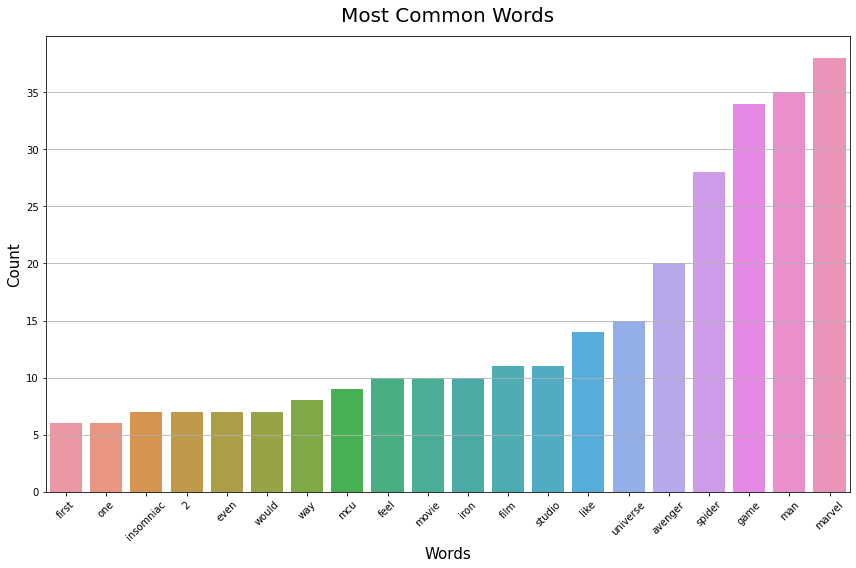

In [16]:
# Define the graph size
plt.figure(figsize=(12,8))
# Create a barplot using the series
sns.barplot(x=word_series.index, y=word_series.values)
# Define title, x-axis label, and y-axis label
plt.title('Most Common Words', fontsize=20, pad=15)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
# Rotate the x-tick labels so they are legible
plt.xticks(rotation=45)
# Add gridlines
plt.grid(axis='y')
# Display the graph
plt.tight_layout()
plt.show()

A word cloud can also be used to display the most common words. The more times a word appears in the text, the larger the word is in the graph.

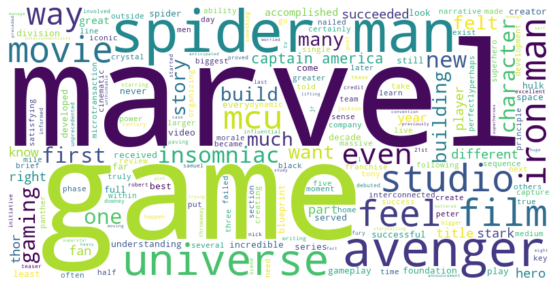

In [17]:
# Create a WordCloud object using the paragraphs variable
#  This is another way to visualize the most common words
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(paragraphs)

# Define the graph size
plt.figure(figsize=(10, 5))
# plot the word could into the graph
plt.imshow(wordcloud, interpolation="bilinear")
# Turn off axes
plt.axis("off")
# Show graph
plt.show()

We have seen the words that populate the text, but to better understand what those words mean in a grammatical structure, we need to perform some parts-of-speech (POS) tagging and name entity recognition (NER).

You can refer to this website for the full list of POS tags and their meaning:
- https://www.ibm.com/docs/en/wca/3.5.0?topic=analytics-part-speech-tag-sets

You can refer to this website for the full list of NER labels and their meaning:
- https://www.dataknowsall.com/ner.html

In [18]:
# Use nltk's built-in method pos_tag to perform POS tagging using the clean_tokens list
#  Display the first 20 tokens and their tags
nltk.pos_tag(clean_tokens[:20])

[('2008', 'CD'),
 ('robert', 'JJ'),
 ('downey', 'NN'),
 ('jr', 'NN'),
 ('debuted', 'VBD'),
 ('tony', 'JJ'),
 ('stark', 'NN'),
 ('iron', 'NN'),
 ('man', 'NN'),
 ('outside', 'IN'),
 ('excellent', 'JJ'),
 ('movie', 'NN'),
 ('right', 'NN'),
 ('iron', 'NN'),
 ('man', 'NN'),
 ('proved', 'VBD'),
 ('one', 'CD'),
 ('influential', 'JJ'),
 ('film', 'NN'),
 ('21st', 'CD')]

It looks like the nltk POS tagger function did pretty well, but it mis-tagged "robert" and "tony" as adjectives instead of nouns.

Let's try it again, but with the spacy POS tagger and capital letters to see if there is a difference. We will also use spacy to perform NER.

For this, we will create a function to repeat the same pre-processing steps in the beginning, but keep the original capital letters.

In [19]:
# Create a function to preprocess the web page content with capital letters
def get_content_cap(web_content):
    # Create the tokenizer, lemmatizer, and regex pattern objects
    wpt = WordPunctTokenizer()
    lemmatizer = WordNetLemmatizer()
    pattern = re.compile(r'[^a-zA-Z0-9\s]')
    
    # Get the text from the web page
    normal_text = [text.get_text() for text in web_content]
    # Tokenize the text
    tokenized_text = [wpt.tokenize(text) for text in normal_text]
    # Remove the stopwords
    no_stop_text = [[word for word in tokens if word.lower() not in stop_words] for tokens in tokenized_text]
    # Lemmatize the text
    lem_text = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in no_stop_text]
    # Remove special characters and punctuation
    regex_text = [[word for word in tokens if not pattern.match(word)] for tokens in lem_text]
    # Remove any empty tokens
    final_text = [[word for word in tokens if word.strip()] for tokens in regex_text]
    # Rejoin the tokens into sentences
    sentences = [' '.join(tokens) for tokens in final_text]
    
    return sentences

In [20]:
# Get the text with its original capital letters
text_cap = get_content_cap(base_text)
# Join the text into one big string
content_cap = '\n\n'.join(text_cap)

In [21]:
# Use the spacy object created in the beginning to convert the text
doc = nlp(content_cap)

# Use spacy's POS tagger to display the orginal text, its lemmatized form, and its POS tag
for token in doc:
    print(f'{token.text:<20} {token.lemma_:<20} {token.pos_:<10}')

2008                 2008                 NUM       
Robert               Robert               PROPN     
Downey               Downey               PROPN     
Jr                   Jr                   PROPN     
debuted              debut                VERB      
Tony                 Tony                 PROPN     
Stark                Stark                PROPN     
Iron                 Iron                 PROPN     
Man                  Man                  PROPN     
Outside              outside              ADP       
excellent            excellent            ADJ       
movie                movie                NOUN      
right                right                INTJ      
Iron                 Iron                 PROPN     
Man                  Man                  PROPN     
proved               prove                VERB      
one                  one                  NUM       
influential          influential          ADJ       
film                 film                 NOUN

It looks like the spacy POS tagger did very well and even correctly tagged "Robert" and "Tony" as proper nouns.

Now let's try NER with spacy.

In [22]:
# Define the colors of the NER labels
colors = {'ORG': 'linear-gradient(90deg, #A1C4FD, #C2E9FB)',
          'DATE': 'linear-gradient(90deg,#A9F1DF, #FFBBBB)',
          'PERSON':'linear-gradient(90deg, #EA8D8D, #A890FE)',
          'CARDINAL':'linear-gradient(90deg, #93A5CF, #E4EfE9)',
          'WORK_OF_ART':'linear-gradient(90deg, #EE9CA7, #FFDDE1)',
          'PRODUCT':'linear-gradient(90deg, #BFF098, #6FD6FF)',
          'NORP':'linear-gradient(90deg, #764BA2, #667EEA)',
          'LOC':'linear-gradient(90deg, #FF5F6D, #FFC371)',
          'GPE':'linear-gradient(90deg, #C6EA8D, #FE90AF)',
          'ORDINAL':'linear-gradient(90deg, #FFECD2, #FCB69F)'}

# Define the NER labels that will be used and their colors
options = {'ents': ['ORG', 'DATE', 'PERSON', 'CARDINAL', 'WORK_OF_ART',
                    'PRODUCT', 'NORP', 'LOC', 'GPE', 'ORDINAL'], 
           'colors':colors}

# Display the text with the NER labels and custom colors
displacy.render(doc, style='ent', jupyter=True, options=options)

It looks like the spacy's NER did a decent job. There are some mistakes like labeling "Venom" as "GPE". GPE is for countries, cities, and states. My favorite is probably the NER labeling "Captain America Thor Hulk" as "WORK_OF_ART".

## Comparison

Now let's compare two different web pages to see how similar they are to each other. The second web page will be from the same website, but the article is about a completely different subject. The cosine similarity should be close to 0 becuase they are not similar, but let's see it that's true.

In [23]:
# Function to clean and tokenize the web page content
def get_page_content(web_content):
    # Create the tokenizer, lemmatizer, and regex pattern objects
    wpt = WordPunctTokenizer()
    lemmatizer = WordNetLemmatizer()
    pattern = re.compile(r'[^a-zA-Z0-9\s]')
    
    # Get the text from the web page
    normal_text = [paragraph.get_text() for paragraph in web_content]
    # Convert the text to lowercase
    lowercase_text = [text.lower() for text in normal_text]
    # Tokenize the text
    tokenized_text = [wpt.tokenize(text) for text in lowercase_text]
    # Remove the stopwords
    no_stop_text = [[word for word in tokens if word not in stop_words] for tokens in tokenized_text]
    # Lemmatize the text
    lem_text = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in no_stop_text]
    # Remove special characters and punctuation
    regex_text = [[word for word in tokens if not pattern.match(word)] for tokens in lem_text]
    # Remove any empty tokens
    final_text = [[word for word in tokens if word.strip()] for tokens in regex_text]
    # Rejoin the tokens into sentences
    sentences = [' '.join(tokens) for tokens in final_text]
    
    return sentences

In [24]:
# Variable to store the URL of the second web page being used
url2 = 'https://www.gameinformer.com/2023/10/13/inside-the-rise-of-boomer-shooters'
# User selected URL
# url2 = input('Please enter the full URL: ')
# Send a request to retrieve the web page's content
page2 = requests.get(url2)
# Retrieve the content is the request was accepted
page_content2 = page2.content
# Use BeautifulSoup to parse the content
soup2 = BeautifulSoup(page_content2, 'html.parser')

In [25]:
# Find the title of the second web page
title2 = soup2.find_all('title')

# Clean the title by removing the HTML tags
cleaned_title2 = [text.get_text() for text in title2]

print(cleaned_title2)

['Inside The Rise Of Boomer Shooters - Game Informer']


In [26]:
# Find all the p tags to get the content
base_text2 = soup2.find_all('p')

# Call the function to get the clean and tokenized text
sentences2 = get_page_content(base_text2)

# Join the text into a big string
paragraphs2 = '\n\n'.join(sentences2)

print(paragraphs2)

banshee speed spark crawling way fuse disaster waiting happen

scarecrow make mistake turning man right shotgun toting farmer barrel pointed face greet shotgun double barreled finger trigger

eclipse bear hug bullet sound sky already hue bloodhound fever dream somehow even redder one moment later already gone

dusk one handful recent game harkening back doom quake era invention fps genre past year boomer shooter like dusk amid evil ultrakill awakened hunger long thought dormant publisher new blood interactive mission ensure remain well fed

1993 shotgun blast thundered throughout million american bedroom echoed across college dormitory office cubicle casting firework burst light onto face whoever witnessed

blast powerful survived journey across globe back withstanding entire generation without fading away afflicted heard strange sickness fanatical desire bully digital devil pile bloody gib e pulpy chunk gore

short discovered doom

doom player space marine barreling military base even

In [27]:
# Create a TfidfVectorizer object
#  TF-IDF determines the frequency of a word in a document in relation to the whole corpus
#  The TF-IDF score is what the cosine similarity will use to determine how similar the two web pages are to each other
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the text to count vectors
vect_matrix = tfidf.fit_transform([paragraphs, paragraphs2])

In [28]:
# Convert the count vector matrix into an array so the cosine similarity can calculate the similarity of the web pages
dense_array = vect_matrix.toarray()

# Calculate the cosine similarity between the two web pages
cosine_sim = cosine_similarity(dense_array)

# Get the cosine similarity
#  The cosine_similarity function creates a matrix where the cosine similarity score of the web pages is located at [0][1]
similarity_score = cosine_sim[0][1]

# Print the titles of the web pages and the cosine similarity score
print(f'Web Page 1: {cleaned_title[0]}')
print(f'Web Page 2: {cleaned_title2[0]}')
print(f'Cosine Similarity: {similarity_score:.2f}')

Web Page 1: The Path To An Avengers Video Game Should Have Always Gone Through Insomniac's Spider-Man - Game Informer
Web Page 2: Inside The Rise Of Boomer Shooters - Game Informer
Cosine Similarity: 0.18


As expected, the cosine similarity score is close to 0. In this case, it is 0.18, meaning there is a small amount of overlap, but the two web pages are very different from each other.

#### Just for fun, here's a word cloud of the second webpage

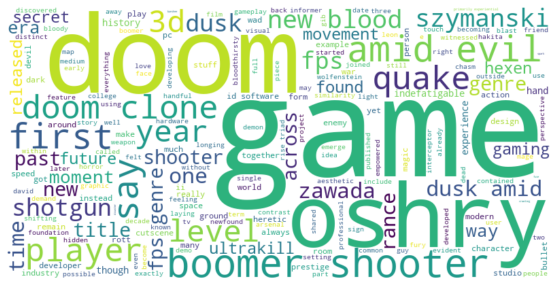

In [29]:
def plot_WC(text):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
plot_WC(paragraphs2)

# Conclusion

In this notebook, we performed a text summarization of a selected web page using BeautifulSoup to scrape the web page as well as numerous NLP techniques like tokenization, lemmatization, POS tagging, and much more. We also compared two web pages to see how similar they were to each other. There were some issues with the POS tagging and NER, but the summarization performed well overall.